# Модель подбора оптимального тарифа

**Содержание:**   
1. [Загрузка данных и общая информация](#section_1)  

2. [Разделение данных на выборки](#section_2)   
    
3. [Исследование моделей](#section_3)  
 3.1. [Функции построения моделей](#section_3_1)  
 3.2. [Модель LogisticRegression](#section_3_2)  
 3.3. [Модель DecisionTreeClassifier](#section_3_3)  
 3.4. [Модель RandomForestClassifier](#section_3_4)  
 3.5. [Модель CatBoostClassifier](#section_3_5)
 
4. [Тестирование лучшей модели](#section_4)  
    
5. [Общий вывод](#section_5)  

**Заказчик исследования:** оператор мобильной связи.

**Цель исследования:** создание модели прогнозирования, способной по поведению пользователя определить максимально подходящий ему тариф: «Смарт» или «Ультра».

**Требования к модели:**  метрика accuracy не должна быть менее 0.75.

**Описание данных**

Исходные данные содержатся в следующих файле "users_behavior.csv":
 - "сalls" — количество звонков,
 - "minutes" — суммарная длительность звонков в минутах,
 - "messages" — количество sms-сообщений,
 - "mb_used" — израсходованный интернет-трафик в Мб,
 - "is_ultra" — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).  
 
Целевой признак - is_ultra;  
Исходные данные уже предобработаны.  

**Импорт библиотек:**

In [1]:
import math
import timeit

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import warnings

from catboost import CatBoostClassifier
from optuna.distributions import FloatDistribution as floatd
from optuna.distributions import IntDistribution as intd
from optuna.integration import OptunaSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, recall_score
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.class_weight import compute_class_weight

warnings.filterwarnings('ignore')

## Загрузка данных и общая информация
<a id="section_1"></a>

Создаем датафрейм:

In [2]:
try:
    df = pd.read_csv('/datasets/users_behavior.csv')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/users_behavior.csv')

Выводим общую информацию по датафрейму:

In [3]:
print('Размер датафрейма:')
print(df.shape)
print('_' * 50)
print()
print('Общая информация о датафрейме:')
print(df.info(memory_usage='deep'))
print('_' * 50)
print()
print('Несколько строк датафрейма:')
display(df.sample(random_state=0, n=5))
print('_' * 50)
print()
print('Количество дубликатов:')
print(df.duplicated().sum())
print('_' * 50)  
print()
print('Описательная статистика числовых значений:')
display(df.describe().T)
print('_' * 50)
print()
print('Количество пропусков:')
print(df.isna().sum())
print()
print('Количество пропусков в процентах:')
print(df.isna().mean()*100)  

Размер датафрейма:
(3214, 5)
__________________________________________________

Общая информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB
None
__________________________________________________

Несколько строк датафрейма:


,calls,minutes,messages,mb_used,is_ultra
2568,82.0,580.09,96.0,21463.80,0
2200,29.0,217.15,46.0,16933.72,0
306,36.0,250.88,49.0,18965.02,0
831,133.0,972.70,83.0,38552.62,0
2781,25.0,155.55,98.0,17856.19,0


__________________________________________________

Количество дубликатов:
0
__________________________________________________

Описательная статистика числовых значений:


,count,mean,std,min,25%,50%,75%,max
calls,3214.0,63.038892,33.236368,0.0,40.0000,62.000,82.0000,244.00
minutes,3214.0,438.208787,234.569872,0.0,274.5750,430.600,571.9275,1632.06
messages,3214.0,38.281269,36.148326,0.0,9.0000,30.000,57.0000,224.00
mb_used,3214.0,17207.673836,7570.968246,0.0,12491.9025,16943.235,21424.7000,49745.73
is_ultra,3214.0,0.306472,0.461100,0.0,0.0000,0.000,1.0000,1.00


__________________________________________________

Количество пропусков:
calls       0
minutes     0
messages    0
mb_used     0
is_ultra    0
dtype: int64

Количество пропусков в процентах:
calls       0.0
minutes     0.0
messages    0.0
mb_used     0.0
is_ultra    0.0
dtype: float64


Проверяем датафрейм на дисбаланс классов:

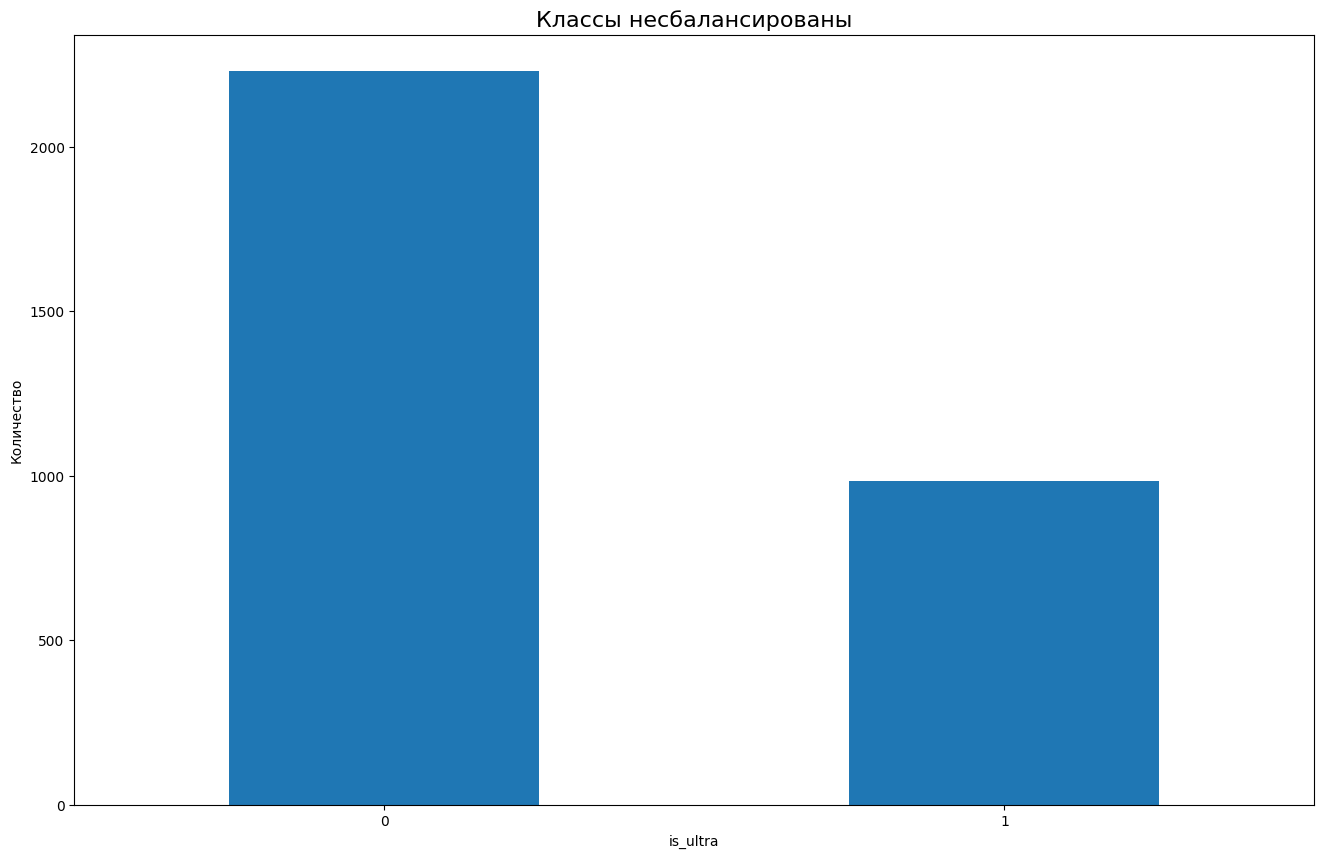

In [4]:
df_all_size = df.groupby('is_ultra')['calls'].count()
fig = plt.figure(figsize=(16,10))
ax = df_all_size.plot.bar()
plt.title('Классы несбалансированы', fontsize=16)
plt.ylabel('Количество')
plt.xticks(rotation=0)
plt.show()

**Вывод:**  
1. В датафрейме содержатся 3214 строк и 5 столбцов. Объем датафрейма - 125.7 KB.
2. Параметры "calls", "minutes", "messages", "mb_used" имеют тип "float64", а "is_ultra" - "int64".
3. Пропущенные значения отсутствуют.
4. Пользователей тарифа "Ультра" от общего количества представленных в датафрейме пользователей - 30.6%.

## Разделение данных на выборки
<a id="section_2"></a>

Задаем значение параметра random_state:

In [5]:
RS = np.random.RandomState(5)

Создаем переменные для признаков и целевого признака:

In [6]:
X = df.drop(['is_ultra'], axis=1)
y = df['is_ultra']

Разделяем данные на обучающую и тестовую выборки в пропорциях 70%-30%:

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=RS)
print(f'Размер обучающей выборки: {X_train.shape[0]}')
print(f'Размер тестовой выборки: {X_test.shape[0]}')

Размер обучающей выборки: 2249
Размер тестовой выборки: 965


Для моделей LogisticRegression, DecisionTreeClassifier и RandomForestClassifier масштабируем числовые признаки. Для модели CatBoostClassifier будут использоваться немасштабированные данные.

In [8]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaler = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
X_test_scaler = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

## Исследование моделей
<a id="section_3"></a>

### Функции построения моделей
<a id="section_3_1"></a>

In [9]:
def roc_auc_diagr(model_dict):
    '''функция отрисовки ROC-кривой'''

    plt.figure(figsize=(10, 10))
    for model_name, model in model_dict.items():
        if model_name == 'CatBoostClassifier': 
            X_train_tmp = X_train
        else:
            X_train_tmp = X_train_scaler
        probabilities_train = model.predict_proba(X_train_tmp)
        probabilities_one_train = probabilities_train[:, 1]
        fpr, tpr, thresholds = roc_curve(y_train, probabilities_one_train)

        ax = plt.plot(fpr, tpr, label=model_name)
    ax = plt.plot([0, 1], [0, 1], linestyle='--', label='Наивная модель')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.legend()
    plt.show()

Гиперпараметры подбираются с помощью OptunaSearchCV.  
Лучшую модель определяем по метрике ROC-AUC.  
В целях определения качества определения каждого из классов дополнительно рассчитываем метрики F1 и Recall.

In [10]:
model_dict = {}
n_counts = 5
skf = StratifiedKFold(n_splits = n_counts, shuffle = True, random_state=RS)

In [11]:
def metrics(model, params, model_name, X_train = X_train_scaler):
    '''функция обучения моделей и расчёта метрик'''
    
    optuna.logging.set_verbosity(optuna.logging.WARNING)                               # отключаем логгирование
    model = OptunaSearchCV(model, params, scoring='roc_auc', cv=skf)                     # передаем данные в OptunaSearchCV
    start_time = timeit.default_timer()                                                # начальное время обучения
    model.fit(X_train, y_train)                                                        # обучаем модель
    time_fit = timeit.default_timer() - start_time                                     # длительность обучения
    start_time = timeit.default_timer()                                                # начальное время предсказания
    roc_auc = model.best_score_                                                        # метрика roc_auc
    y_pred = model.best_estimator_.predict(X_train)                                    # делаем предсказание
    time_pred = timeit.default_timer() - start_time                                    # длительность предсказания
    
    recall = recall_score(y_train, y_pred).round(3)                                    # метрика recall
    f1 = f1_score(y_train, y_pred).round(3)                                            # метрика f1
    accuracy = accuracy_score(y_train, y_pred).round(3) 
    
    print('Roc_Auc: {}'.format(roc_auc))                                               # выводим метрику roc_auc
    print('Recall: {}'.format(recall))                                                 # выводим метрику recall
    print('F1: {}'.format(f1))                                                         # выводим метрику f1
    print('Accuracy: {}'.format(accuracy))                                             # выводим метрику accuracy

    model_dict[model_name] = model.best_estimator_
    
    return model, accuracy, recall, roc_auc, f1, y_pred, time_fit, time_pred

### Модель LogisticRegression
<a id="section_3_2"></a>

Подбираемый гиперпараметр - "C". Классы сбалансированы методом взвешивания классов.

In [12]:
params_lr = {'C': intd(1, 10, False, 1)}                                     # значения гиперпараметров модели для подбора
model_lr = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=RS)        # создаем модель

In [13]:
best_model_lr, accuracy_lr, recall_lr, roc_auc_lr, f1_lr, pred_lr, time_fit_lr, time_pred_lr = metrics(model_lr,
                                                                                                       params_lr,
                                                                                                       'LogisticRegression')

Roc_Auc: 0.6684979263129056
Recall: 0.604
F1: 0.5
Accuracy: 0.631


### Модель DecisionTreeClassifier
<a id="section_3_3"></a>

Подбираемый гиперпараметры:  
 - min_samples_leaf;
 - min_samples_split;
 - max_depth.  
 
Классы сбалансированы методом взвешивания классов.

In [14]:
params_dtc = {'min_samples_leaf' : intd(1, 10, False, 1),         # значения гиперпараметров модели для подбора
              'min_samples_split' : intd(2, 10, False, 1),
              'max_depth' : intd(1, 10, False, 1)}
model_dtc = DecisionTreeClassifier(class_weight='balanced', random_state=RS)               # создаем модель

In [15]:
best_model_dtc, accuracy_dtc, recall_dtc, roc_auc_dtc, f1_dtc, pred_dtc, time_fit_dtc, time_pred_dtc = metrics(model_dtc,
                                                                                                               params_dtc,
                                                                                                               'DecisionTreeClassifier')

Roc_Auc: 0.778913813143026
Recall: 0.792
F1: 0.728
Accuracy: 0.819


### Модель RandomForestClassifier
<a id="section_3_4"></a>

Подбираемый гиперпараметры:  
 - min_samples_leaf;
 - min_samples_split;
 - max_depth;  
 - n_estimators.  
    
Классы сбалансированы методом взвешивания классов.

In [16]:
params_rfc = {'min_samples_leaf' : intd(1, 10, False, 1),                     # значения гиперпараметров модели для подбора
              'min_samples_split' : intd(2, 10, False, 1),
              'max_depth' : intd(1, 10, False, 1),
              'n_estimators' : intd(100, 150, False, 10)}
model_rfc = RandomForestClassifier(class_weight='balanced', random_state=RS)                   # создаем модель

In [17]:
best_model_rfc, accuracy_rfc, recall_rfc, roc_auc_rfc, f1_rfc, pred_rfc, time_fit_rfc, time_pred_rfc = metrics(model_rfc,
                                                                                                               params_rfc,
                                                                                                               'RandomForestClassifier')

Roc_Auc: 0.8213822365440899
Recall: 0.685
F1: 0.763
Accuracy: 0.869


### Модель CatBoostClassifier
<a id="section_3_5"></a>

Подбираемый гиперпараметры:  
 - learning_rate;
 - depth;  
 - l2_leaf_reg.  
    
Классы сбалансированы методом взвешивания классов.

In [18]:
params_cb = {     
    'learning_rate' : floatd(0.001, 0.005, False, 0.002),                                                               # значения гиперпараметров модели для подбора
    'depth' : intd(6, 10, False, 2),
    'l2_leaf_reg': intd(2, 4, False, 2)
}
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))
model_cb = CatBoostClassifier(verbose=False,                          # создаем модель
                             iterations = 1000,
                             class_weights=class_weights)

In [19]:
best_model_cb, accuracy_cb, recall_cb, roc_auc_cb, f1_cb, pred_cb, time_fit_cb, time_pred_cb = metrics(model_cb,
                                                                                                       params_cb,
                                                                                                       'CatBoostClassifier',
                                                                                                       X_train)

Roc_Auc: 0.8261801300360488
Recall: 0.707
F1: 0.714
Accuracy: 0.827


**Сравнение моделей**

Строим ROC-кривые:

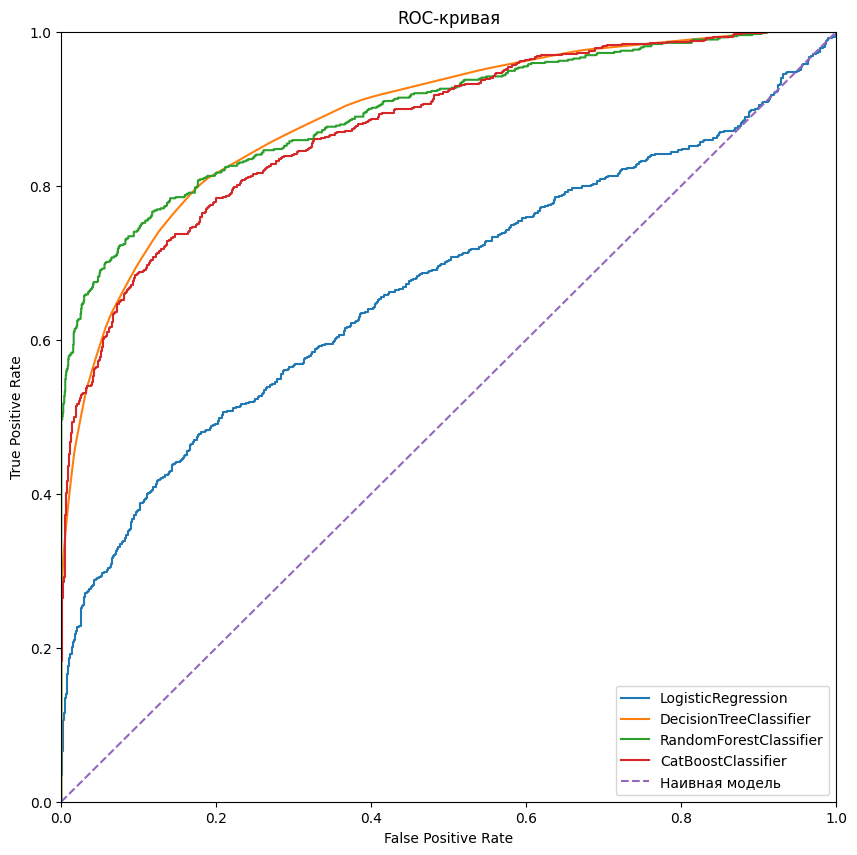

In [20]:
roc_auc_diagr(model_dict)

Сравнительная таблица:

In [21]:
# собираем таблицу
df_best_model = pd.DataFrame({'model' : ['LogisticRegression', 'RandomForestClassifier', 'DecisionTreeClassifier', 'CatBoostClassifier'],
                              'accuracy' : [accuracy_lr, accuracy_rfc, accuracy_dtc, accuracy_cb],
                              'recall' : [recall_lr, recall_rfc, recall_dtc, recall_cb],
                              'f1' : [f1_lr, f1_rfc, f1_dtc, f1_cb],
                              'roc_auc' : [roc_auc_lr, roc_auc_rfc, roc_auc_dtc, roc_auc_cb],
                              'time_fit' : [time_fit_lr, time_fit_rfc, time_fit_dtc, time_fit_cb],
                              'time_pred' : [time_pred_lr, time_pred_rfc, time_pred_dtc, time_pred_cb],
                              'best_model' : [best_model_lr, best_model_rfc, best_model_dtc, best_model_cb],
                              'y_pred' : [pred_lr, pred_rfc, pred_dtc, pred_cb]})
df_best_model[['model', 'accuracy', 'recall', 'f1', 'roc_auc', 'time_fit', 'time_pred']]                # выводим таблицу

,model,accuracy,recall,f1,roc_auc,time_fit,time_pred
0,LogisticRegression,0.631,0.604,0.500,0.668498,0.311968,0.000900
1,RandomForestClassifier,0.869,0.685,0.763,0.821382,12.808303,0.022469
2,DecisionTreeClassifier,0.819,0.792,0.728,0.778914,0.447669,0.001027
3,CatBoostClassifier,0.827,0.707,0.714,0.826180,473.171185,0.002230


Выделяем из таблицы модель с наибольшим ROC-AUC:

In [22]:
best_model_row = df_best_model.loc[df_best_model['roc_auc'] == df_best_model['roc_auc'].max()]
best_model = best_model_row.iloc[0, 7]
best_model_name = best_model_row.iloc[0, 0]
best_model_params = best_model_row.iloc[0, 7].best_params_

In [23]:
print('Лучшая модель: {}'.format(best_model_name))
print('Параметры лучшей модели: {}'.format(best_model_params))

Лучшая модель: CatBoostClassifier
Параметры лучшей модели: {'learning_rate': 0.003, 'depth': 8, 'l2_leaf_reg': 2}


**Важность основных факторов**

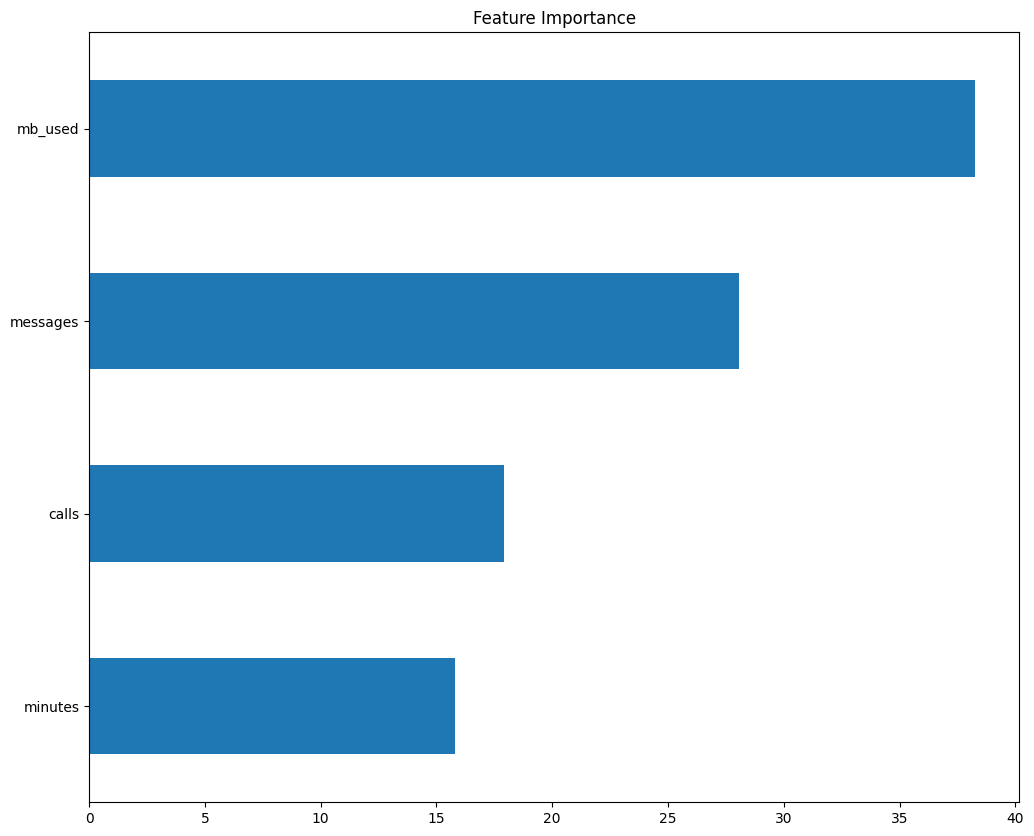

In [24]:
if best_model_row.iloc[0, 0] == 'LogisticRegression':
    importance = best_model_lr.best_estimator_.coef_[0]      # получаем коэффициенты признаков для модели LogisticRegression
else:
    # получаем коэффициенты признаков для других моделей
    importance = best_model_row.iloc[0, 7].best_estimator_.feature_importances_
# собираем признаки в серию
if best_model_row.iloc[0, 0] == 'CatBoostClassifier':
    importance_features = pd.Series(importance, index=X_train.columns).sort_values(ascending=True).tail(10)
else:
    importance_features = pd.Series(importance, index=X_train_scaller.columns).sort_values(ascending=True).tail(10)
plt.figure(figsize=(12,10))                                           # задаем размер окна диаграммы
importance_features.plot(kind='barh',title = 'Feature Importance')    # визуализируем диаграмму
plt.show()

Наиболее важный признак - израсходованный интернет-трафик.

**Вывод:**  
Рассмотрены модели LogisticRegression, DecisionTreeClassifier, RandomForestClassifier и CatBoost.  
Модель с наибольшим значением Accuracy - RandomForestClassifier.  
Метрики лучшей модели:  
 - accuracy: 0.887;  
 - recall: 0.737;  
 - f1: 0.799;  
 - roc_auc: 0.819490;  
 - время обучения (секунд): 10.865167;  
 - время предсказания (секунд): 0.021546.  
 
Параметры лучшей модели:  
 - min_samples_leaf (минимальное количество объектов в листе) - 3;  
 - min_samples_split (минимальное количество примеров для разделения) - 3;  
 - max_depth (максимальная глубина деревьев) - 10;  
 - n_estimators (число деревьев) - 110.  
 
Наиболее важный признак - израсходованный интернет-трафик.

## Тестирование лучшей модели
<a id="section_4"></a>

**Расчёт метрик лучшей модели на тестовой выборке**

Рассчитываем метрики на тестовой выборке:

In [25]:
if best_model_name == 'CatBoostClassifier': 
    X_test_tmp = X_test
else:
    X_test_tmp = X_test_scaler

In [26]:
y_pred = best_model_row.iloc[0, 7].predict(X_test_tmp)

In [27]:
roc_auc = roc_auc_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
print('Roc-Auc: {:.3f}'.format(roc_auc))
print('Recall: {:.3f}'.format(recall))
print('F1: {:.3f}'.format(f1))
print('Accuracy: {:.3f}'.format(accuracy))

Roc-Auc: 0.748
Recall: 0.655
F1: 0.651
Accuracy: 0.784


**Матрица ошибок**

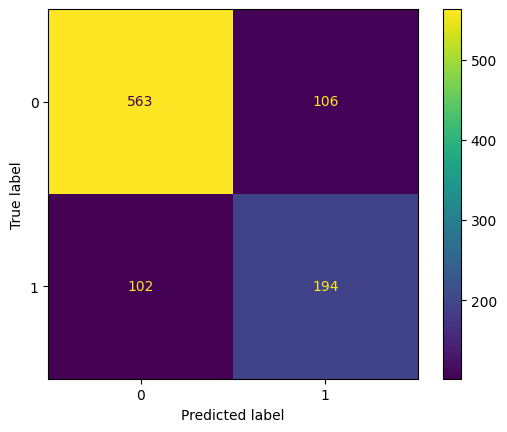

In [28]:
cm = confusion_matrix(y_test, y_pred)                                           # рассчитываем матрицу ошибок
disp = ConfusionMatrixDisplay(confusion_matrix=cm)                              
disp.plot()                                                                     # визуализируем матрицу ошибок
plt.show()

**Проверка модели на адекватность**

In [29]:
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=RS)
dummy_clf.fit(X_test, y_test)
dummy_accuracy = dummy_clf.score(X_test, y_test)
if accuracy > dummy_accuracy:
    print('Accuracy для выбранной модели ({:.3f}) выше, чем accuracy для "наивного" алгоритма ({:.3f}), модель можно считать адекватной.'
          .format(accuracy, dummy_accuracy))
else:
    print('Accuracy для выбранной модели ({:.3f}) не выше, чем accuracy для "наивного" алгоритма ({:.3f}),\n модель нельзя считать адекватной.'
          .format(accuracy, dummy_accuracy))

Accuracy для выбранной модели (0.784) выше, чем accuracy для "наивного" алгоритма (0.693), модель можно считать адекватной.


**Вывод:**  
1. Метрики лучшей модели на тестовой выборке:  

 - Roc-Auc: 0.748;
 - Recall: 0.601;
 - F1: 0.654;
 - Accuracy: 0.805.  

2. Accuracy для выбранной модели (0.808) выше, чем accuracy для "наивного" алгоритма (0.6932642487046632), модель можно считать адекватной.  

## Общий вывод
<a id="section_5"></a>

**Загрузка данных и общая информация**  

1. В датафрейме содержатся 3214 строк и 5 столбцов. Объем датафрейма - 125.7 KB.
2. Параметры "calls", "minutes", "messages", "mb_used" имеют тип "float64", а "is_ultra" - "int64".
3. Пропущенные значения отсутствуют.
4. Пользователей тарифа "Ультра" от общего количества представленных в датафрейме пользователей - 30.6%.  

**Исследование моделей**  

Рассмотрены модели LogisticRegression, DecisionTreeClassifier, RandomForestClassifier и CatBoost.  
Модель с наибольшим значением Accuracy - RandomForestClassifier.  
Метрики лучшей модели:  
 - Accuracy: 0.887;  
 - Recall: 0.737;  
 - F1: 0.799;  
 - Roc_Auc: 0.819490;  
 - время обучения (секунд): 10.865167;  
 - время предсказания (секунд): 0.021546.  
 
Параметры лучшей модели:  
 - min_samples_leaf (минимальное количество объектов в листе) - 3;  
 - min_samples_split (минимальное количество примеров для разделения) - 3;  
 - max_depth (максимальная глубина деревьев) - 10;  
 - n_estimators (число деревьев) - 110. 
 
Наиболее важный в плане прогнозирования признак - израсходованный интернет-трафик.  
 
**Проверка лучшей модели**  

1. Метрики лучшей модели на тестовой выборке:  

 - Roc-Auc: 0.748;
 - Recall: 0.601;
 - F1: 0.654;
 - Accuracy: 0.805.  

2. Accuracy для выбранной модели (0.808) выше, чем accuracy для "наивного" алгоритма (0.6932642487046632), модель можно считать адекватной.   